[Advanced RAG For Tables](https://freedium.cfd/https://ai.plainenglish.io/advanced-rag-07-exploring-rag-for-tables-5c3fc0de7af6)

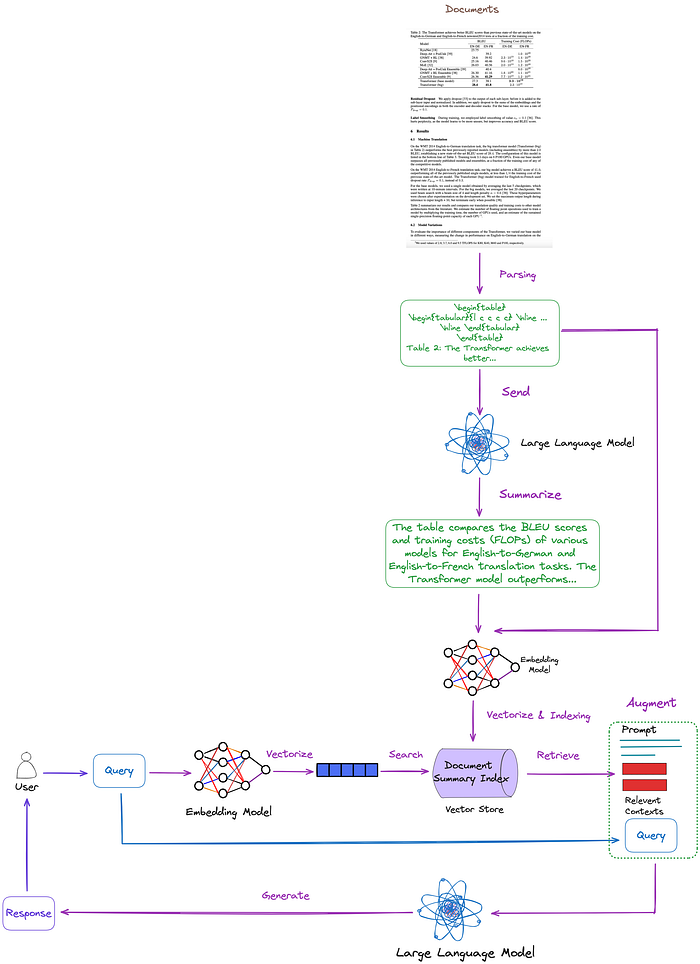

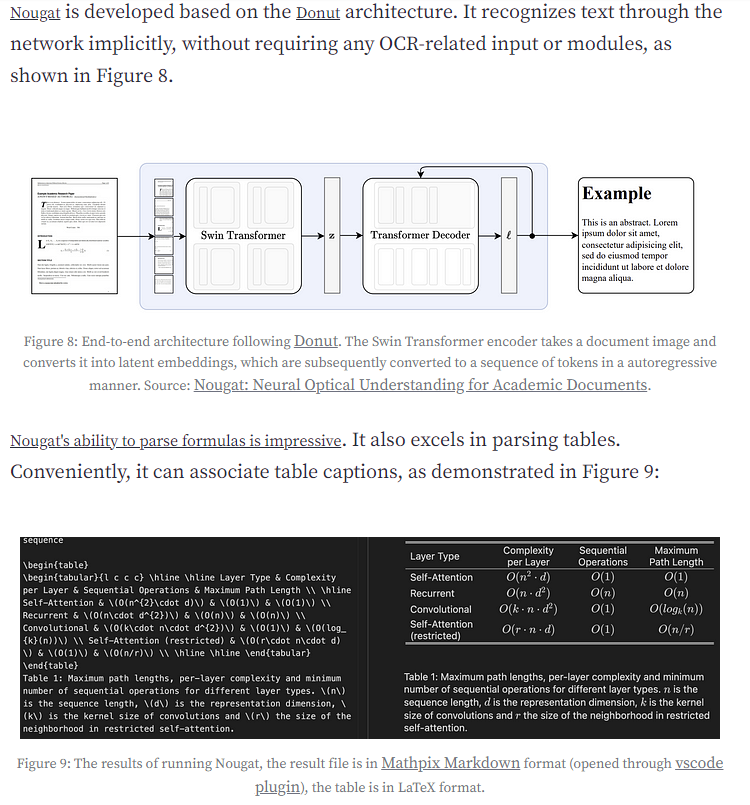

In [4]:
import os

import subprocess
import uuid

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import AzureOpenAIEmbeddings
from langchain.chat_models import AzureChatOpenAI

from langchain_core.runnables import RunnablePassthrough
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
def june_run_nougat(file_path, output_dir):
    # Run Nougat and store results as Mathpix Markdown
    cmd = ["nougat", file_path, "-o", output_dir, "-m", "0.1.0-base", "--no-skipping"]
    res = subprocess.run(cmd) 
    if res.returncode != 0:
        print("Error when running nougat.")
        return res.returncode
    else:
        print("Operation Completed!")
        return 0

def june_get_tables_from_mmd(mmd_path):
    f = open(mmd_path)
    lines = f.readlines()
    res = []
    tmp = []
    flag = ""
    for line in lines:
        if line == "\\begin{table}\n":
            flag = "BEGINTABLE"
        elif line == "\\end{table}\n":
            flag = "ENDTABLE"
        
        if flag == "BEGINTABLE":
            tmp.append(line)
        elif flag == "ENDTABLE":
            tmp.append(line)
            flag = "CAPTION"
        elif flag == "CAPTION":
            tmp.append(line)
            flag = "MARKDOWN"
            print('-' * 100)
            print(''.join(tmp))
            res.append(''.join(tmp))
            tmp = []

    return res

## Nougat For Detecting tables and Convert them into Markdown

In [3]:
file_path = "Documents/attention-is-all-you-need-Paper.pdf"
output_dir = "Documents"

# if june_run_nougat(file_path, output_dir) == 1:
#     import sys
#     sys.exit(1)

mmd_path = output_dir + '/' + os.path.splitext(file_path)[0].split('/')[-1] + ".mmd" 
tables = june_get_tables_from_mmd(mmd_path)

----------------------------------------------------------------------------------------------------
\begin{table}
\begin{tabular}{l c c c} \hline \hline Layer Type & Complexity per Layer & Sequential Operations & Maximum Path Length \\ \hline Self-Attention & \(O(n^{2}\cdot d)\) & \(O(1)\) & \(O(1)\) \\ Recurrent & \(O(n\cdot d^{2})\) & \(O(n)\) & \(O(n)\) \\ Convolutional & \(O(k\cdot n\cdot d^{2})\) & \(O(1)\) & \(O(log_{k}(n))\) \\ Self-Attention (restricted) & \(O(r\cdot n\cdot d)\) & \(O(1)\) & \(O(n/r)\) \\ \hline \hline \end{tabular}
\end{table}
Table 1: Maximum path lengths, per-layer complexity and minimum number of sequential operations for different layer types. \(n\) is the sequence length, \(d\) is the representation dimension, \(k\) is the kernel size of convolutions and \(r\) the size of the neighborhood in restricted self-attention.

----------------------------------------------------------------------------------------------------
\begin{table}
\begin{tabular}{l c c 

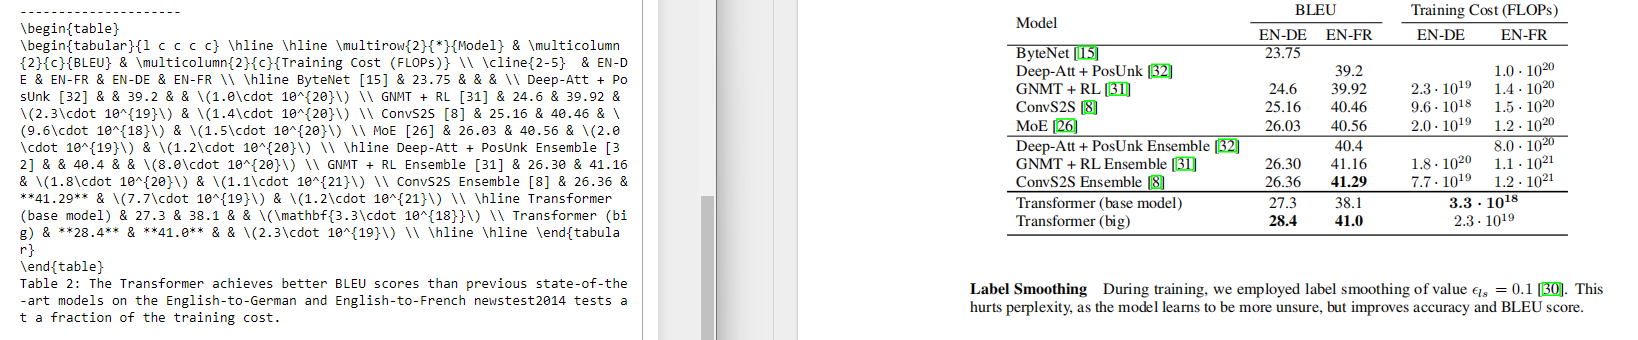

In [6]:
#tables

In [8]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \ 
Give a concise summary of the table or text. The table is formatted in LaTeX, and its caption is in plain text format: {element}  """

prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = AzureChatOpenAI(temperature = 0, model = "gpt-35-turbo")

summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# Get table summaries
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})
print(table_summaries)

['Table 1 provides information on the maximum path lengths, per-layer complexity, and minimum number of sequential operations for different layer types. The table includes the complexity per layer, sequential operations, and maximum path length for each layer type, including self-attention, recurrent, convolutional, and restricted self-attention. The variables \\(n\\), \\(d\\), \\(k\\), and \\(r\\) represent the sequence length, representation dimension, kernel size of convolutions, and size of the neighborhood in restricted self-attention, respectively.', 'The table shows the BLEU scores and training costs of various models for English-to-German and English-to-French translation tasks. The Transformer model achieves the highest BLEU scores compared to previous state-of-the-art models, while also having significantly lower training costs.']


In [10]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name = "summaries", embedding_function = AzureOpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore = vectorstore,
    docstore = store,
    id_key = id_key,
    search_kwargs={"k": 1} # Solving Number of requested results 4 is greater than number of elements in index..., updating n_results = 1
)

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content = s, metadata = {id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

In [12]:
#summary_tables

In [13]:
# Prompt template
template = """Answer the question based only on the following context, which can include text and tables, 
there is a table in LaTeX format and a table caption in plain text format:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
model = AzureChatOpenAI(temperature = 0, model = "gpt-35-turbo")


# Simple RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)


print(chain.invoke("when layer type is Self-Attention, what is the Complexity per Layer?"))  # Query about table 1

The Complexity per Layer when the layer type is Self-Attention is \(O(n^{2}\cdot d)\).


In [15]:
print(chain.invoke("What is the ByteNet BLEU EN-DE score?"))  # Query about table 2

The ByteNet BLEU EN-DE score is 23.75.


In [16]:
print(chain.invoke("What is the GNMT+RL BLEU EN-FR score?"))

The GNMT+RL BLEU EN-FR score is 39.92.


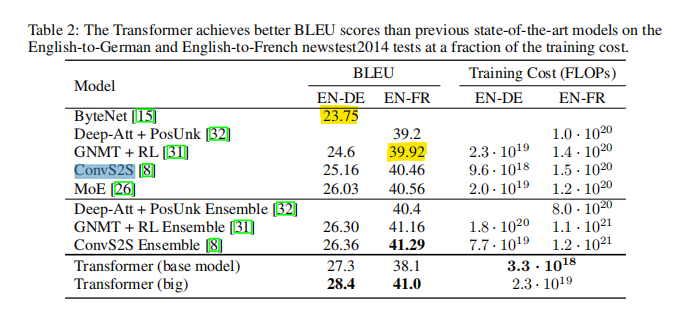